In [14]:
import jax.numpy as np
from jax import grad, jit, vmap
from jax import random, api
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

from svgd import SVGD
import metrics
import utils
import plot

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import warnings

cpu


In [2]:
dist = metrics.Gaussian(0, 1)

In [3]:
n = 100
d = 1
stepsize = 0.01
L = 300
svgd_adaptive = SVGD(dist, n_iter_max=L, adaptive_kernel=True, particle_shape=(n, d))

In [4]:
x0 = svgd_adaptive.initialize()
xout, log = svgd_adaptive.svgd(x0, stepsize, bandwidth=0, n_iter=L)
xout.block_until_ready()
print()

JIT COMPILING svgd...
...done compiling svgd after 0.8738744258880615 seconds.



# compare `jit`ted and non`jit`ted times

In [5]:
m = 10

## Using jit

In [6]:
times_j = []

for _ in tqdm(range(m)):
    x0 = svgd_adaptive.initialize()
#     svgd_adaptive.newkey()
    st = time.time()
    xout, log = svgd_adaptive.svgd(x0, stepsize, bandwidth=0, n_iter=L)
    xout = xout.block_until_ready()
    end = time.time()
    times_j.append(end - st)
times_j = np.array(times_j)
print("mean time:", np.mean(times_j), "s")
print("stdev:", np.std(times_j), "s")

100%|██████████| 10/10 [00:08<00:00,  1.11it/s]

mean time: 0.8945612 s
stdev: 0.025979277 s


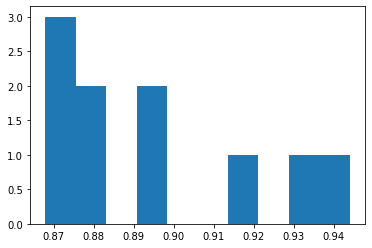

In [7]:
_ = plt.hist(times_j)

## Without jit

In [10]:
times_nojit = []
rkey = random.PRNGKey(0)

with api.disable_jit():
    for _ in tqdm(range(m)):
        x0 = svgd_adaptive.initialize()
        st = time.time()
        xout, log = svgd_adaptive.svgd(x0, stepsize, bandwidth=0, n_iter=L)
        xout = xout.block_until_ready()
        end = time.time()
        times_nojit.append(end - st)
times_nojit = np.array(times_nojit1)
print("mean time:", np.mean(times_nojit1), "s")
print("stdev:", np.std(times_nojit), "s")

  0%|          | 0/10 [00:00<?, ?it/s]

JIT COMPILING svgd...


  0%|          | 0/10 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
_ = plt.hist(times_nojit)

## Final comparison

/home/lauro/.virtualenvs/msc-thesis/lib/python3.6/site-packages/numpy/lib/histograms.py:908: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


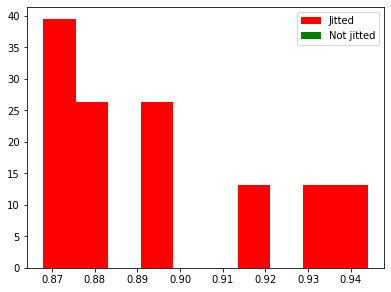

In [11]:
cols = ["r", "g"]
labels = ["Jitted", "Not jitted"]

fig = plt.figure(1, figsize=[6.4, 4.8])
for i, times in enumerate([times_j, times_nojit]):
    plt.hist(times, color=cols[i], label=labels[i], density=True)
    
_ = plt.legend()

# scaling with $n$

In [20]:
def compile_and_time(n, d, n_iter_max, n_iter):
    svgd_fix = SVGD(dist, n_iter_max=n_iter_max, adaptive_kernel=False, particle_shape=(n,d))
    
    h = 1
    stepsize = 0.01
    # run once to compile
    x0 = svgd_fix.initialize()
    x, _ = svgd_fix.svgd(x0, stepsize, bandwidth=h, n_iter=n_iter)
    if np.any(np.isnan(x)):
        warnings.warn("Nans", RuntimeWarning)
    
    
    # run again to time
    x0 = svgd_fix.initialize()
    
    st = time.time()
    x, _ = svgd_fix.svgd(x0, stepsize, bandwidth=h, n_iter=n_iter)
    x.block_until_ready()
    end = time.time()
    
    if np.any(np.isnan(x)):
        warnings.warn("Nans", RuntimeWarning)
    
    return end - st # runtime in seconds

In [35]:
ngrid = np.arange(100, 2200, step=40)
d = 1
n_iter_max = 300
n_iter = n_iter_max
# ntimes = []
for n in ngrid:
    ntimes.append(compile_and_time(n, d, n_iter_max, n_iter))

JIT COMPILING svgd...
...done compiling svgd after 0.6957311630249023 seconds.
JIT COMPILING svgd...
...done compiling svgd after 0.5820350646972656 seconds.
JIT COMPILING svgd...
...done compiling svgd after 0.5586040019989014 seconds.
JIT COMPILING svgd...
...done compiling svgd after 1.1020703315734863 seconds.
JIT COMPILING svgd...
...done compiling svgd after 0.5834436416625977 seconds.
JIT COMPILING svgd...
...done compiling svgd after 0.5462853908538818 seconds.
JIT COMPILING svgd...
...done compiling svgd after 0.7488389015197754 seconds.
JIT COMPILING svgd...
...done compiling svgd after 0.7334587574005127 seconds.
JIT COMPILING svgd...
...done compiling svgd after 0.7822449207305908 seconds.
JIT COMPILING svgd...
...done compiling svgd after 0.9273734092712402 seconds.
JIT COMPILING svgd...
...done compiling svgd after 0.7575263977050781 seconds.
JIT COMPILING svgd...
...done compiling svgd after 0.7642476558685303 seconds.
JIT COMPILING svgd...
...done compiling svgd after 0

KeyboardInterrupt: 

In [ ]:
qgrid = np.arange(70) / 11
_ = plt.plot(ngrid, ntimes, ".")
# _ = plt.plot(qgrid**2)